# Nishimori temperature Bethe-Hessian Quasi-Cyclic graph clustering

## ⬇️ Step 0 : Libraries load

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from NB_clustering import _temperature_optimizations
from NB_clustering import NB_clustering as NB
from NB_clustering.qc2sparse import build_sparse_matrix

## 🔍 Step 1: Data preparation and graph preparation

In [61]:
# Загрузка данных из файла (формат: one row - one object, feature after space)
full_data = np.loadtxt('features_small.dat')

# Make label (first half - class 0, second half - класс 1)
half_len = full_data.shape[0] // 2
true_labels = np.concatenate((np.zeros(half_len), np.ones(half_len)))

# Make graph from parity-check matrix
graph = build_sparse_matrix('16_16_375girth6upGirth6emd0w3.txt')

# 🎯 Step 2: Example of feature selection

In [63]:
def get_top_n_discriminative_features(X_class_0, X_class_1, top_n):
    """Choice top_n the most distinguishable features between classes"""
    # Mathematical expectation for each feature for each class
    mean_class_0 = np.mean(X_class_0, axis=0)
    mean_class_1 = np.mean(X_class_1, axis=0)

    # Mathematical expectations of features between classes
    diff_means = np.abs(mean_class_0 - mean_class_1)

    # Sort the features in descending order of the difference modulus
    sorted_indices = np.argsort(diff_means)[::-1]

    # Top most discriminatory features
    return sorted_indices[:top_n]

top_n = get_top_n_discriminative_features(full_data[:full_data.shape[0] // 2], full_data[full_data.shape[0] // 2:], 128)

# 🧠 Step 3: Initialization of model

In [65]:
model = NB.NishimoriBetheSpectralClustering(
    adjaceny_matrix=graph, # Adjacency matrix of a graph
    n_clusters=2,        # Number of clusters
    kernel=None,    # Kernel, optional for the classifier. In clustering mode None
    sim='cos',        # use cosine metric. exist pearson, mahalanobis, chebyshev, manhattan, minkowski, euclidean
    is_z_scoring=True,  # On z score optimization
    state='cluster'      # Mode of algorithm (clustering(unsupervised labeling), classification(supervised))
)

# ⚙️ Step 4: Training and inference

In [70]:
prediction = model.fit(
    train=full_data[:, top_n],  # Choice most important features
    train_labels=np.zeros(2 * half_len)  # Fake label (used for cluster mode)
)

Dichotomy didn't converge to required precision. Returning best approximation.


# 📊 Step 5: Result visualization

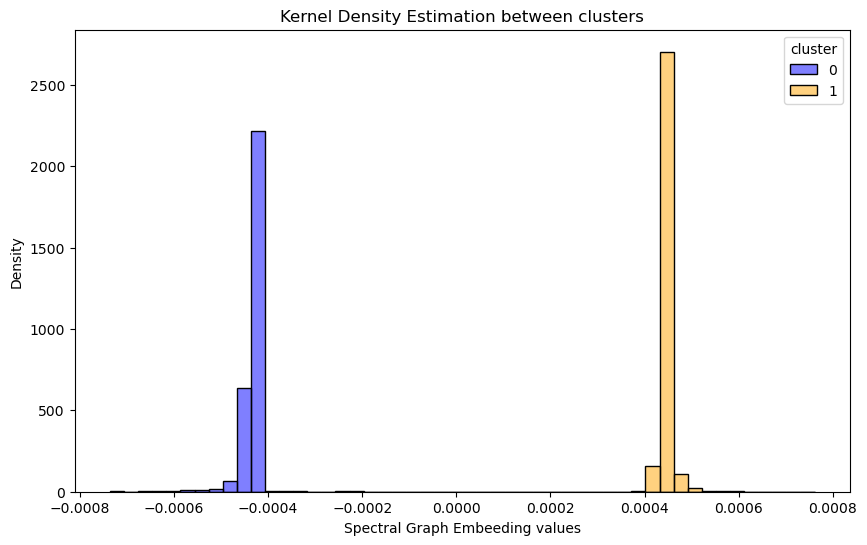

In [72]:
estimated_embedding = model.embedding

plt.figure(figsize=(10, 6))
sns.histplot(data=pd.DataFrame({
    'embedding': estimated_embedding,
    'cluster': prediction
}), x='embedding', hue='cluster', bins=50, alpha=0.5, palette=['blue', 'orange'])

plt.title('Kernel Density Estimation between clusters')
plt.xlabel('Spectral Graph Embeeding values')
plt.ylabel('Density')
plt.show()

# 📈 Step 6: Overlap estimation

In [76]:
def calculate_overlap(estimated_labels, true_labels):
    """
    Computes the overlap between predicted and true labels using the formula:
    Overlap = abs(2*(sum(estimated_l == true_l)/n - 0.5)
    
    Parameters:
    estimated_labels -- array of predicted labels
    true_labels -- array of true labels
    
    Returns:
    Overlap value between 0 and 1
    
    Evaluation scale:

    0.0 - Random guessing

    0.5 - Good separation (~75% accuracy)

    1.0 - Perfect match
    """
    n = len(true_labels)
    matches = sum(estimated_labels == true_labels)
    overlap = abs(2 * (matches / n - 0.5))
    return overlap

print(f"Clustering overlap: {calculate_overlap(prediction, true_labels):.3f}")

Clustering overlap: 0.995
